# Anime-Or-Not

## library import

In [ ]:
import kagglehub
import os
from pathlib import Path

import numpy as np
import matplotlib.pyplot as plt

import torch
from torch import nn
from torchvision import datasets, transforms, models
from  torch.utils.data import DataLoader, random_split, Dataset
from  torchinfo import summary

import random
from PIL import Image


In [60]:
# Setup device-agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

## download images

In [61]:
# download latest version data

path = kagglehub.dataset_download("kanakmittal/anime-and-cartoon-image-classification")
print("Path to dataset files:", path)

# then copy the files to the desired location --> ../data/

Path to dataset files: C:\Users\ahnaf\.cache\kagglehub\datasets\kanakmittal\anime-and-cartoon-image-classification\versions\1


now copy the downloaded `Training Data/` to `../data/`

## load images

In [62]:
data_path = Path("../data/")
image_path = data_path / "Training Data"

 # check if the image folder exists
if image_path.is_dir():
    print(f"'{image_path}' directory exists. Good to go.")
else:
    print(f"Did not find '{image_path}' directory, please download the dataset and extract it to the correct location: '{data_path}'")

'..\data\Training Data' directory exists. Good to go.


In [63]:
def walk_through_dir(dir_path):
  """
  Walks through dir_path returning its contents.
  Args:
    dir_path (str or pathlib.Path): target directory
  
  Returns:
    A print out of:
      number of subdiretories in dir_path
      number of images (files) in each subdirectory
      name of each subdirectory
  """
  for dirpath, dirnames, filenames in os.walk(dir_path):
    print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

In [64]:
walk_through_dir(image_path)

There are 2 directories and 0 images in '..\data\Training Data'.
There are 51 directories and 0 images in '..\data\Training Data\Anime'.
There are 0 directories and 66 images in '..\data\Training Data\Anime\Ace of Diamond'.
There are 0 directories and 89 images in '..\data\Training Data\Anime\Akame ga Kill!'.
There are 0 directories and 86 images in '..\data\Training Data\Anime\Angel Beats'.
There are 0 directories and 79 images in '..\data\Training Data\Anime\Anohana The Flower We Saw That Day'.
There are 0 directories and 86 images in '..\data\Training Data\Anime\Attack on Titan'.
There are 0 directories and 89 images in '..\data\Training Data\Anime\Baccano'.
There are 0 directories and 81 images in '..\data\Training Data\Anime\Black Butler'.
There are 0 directories and 90 images in '..\data\Training Data\Anime\Black Cat'.
There are 0 directories and 87 images in '..\data\Training Data\Anime\Black Lagoon'.
There are 0 directories and 80 images in '..\data\Training Data\Anime\Bleach'.

### Visualize an image

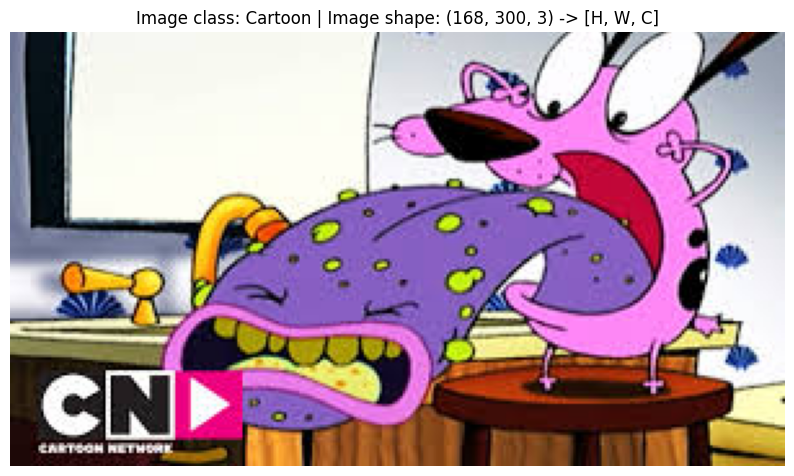

In [65]:
random.seed(150)

image_path_list = list(image_path.glob("**/*.jpg"))
random_image_path = random.choice(image_path_list)
image_class = random_image_path.parent.parent.name

img = Image.open(random_image_path)

# Turn the image into an array
img_as_array = np.asarray(img)

# Plot the image with matplotlib
plt.figure(figsize=(10, 7))
plt.imshow(img_as_array)
plt.title(f"Image class: {image_class} | Image shape: {img_as_array.shape} -> [H, W, C]")
plt.axis(False);

## load images into pytorch

before we can use our image data with pytorch we need to:

- turn it into `tensors` (numerical representations of our images)
- turn it into a `torch.utils.data.Dataset` and subsequently a `torch.util.data.DataLoader`

### transform

In [66]:
# Define transformations (resize, normalize, convert to tensor)

img_resize = (224, 224) # Resize images to 224x224 for ResNet

train_data_transform = transforms.Compose([
    transforms.Resize(img_resize),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomApply([transforms.RandomRotation(degrees=(-30, 30))], p=0.5),
    transforms.ToTensor(),  # Convert to tensor
    # transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]), # TODO: how to set these values?
]) # TODO: try with different transformations

test_data_transform = transforms.Compose([
    transforms.Resize(img_resize),
    transforms.ToTensor(),  # Convert to tensor
])

In [67]:
# Define a wrapper to apply different transforms, use separate transforms for training and testing
class TransformedDataset(torch.utils.data.Dataset):
    def __init__(self, subset, transform):
        self.dataset = subset.dataset
        self.indices = subset.indices
        self.transform = transform

    def __len__(self):
        return len(self.indices)

    def __getitem__(self, idx):
        img, label = self.dataset[self.indices[idx]]  # Get image & label
        img = self.transform(img)  # Apply transform
        return img, label


with this composition of transforms, let's try them out on various images:

In [68]:
def plot_transformed_images(image_paths, transform, n=3, seed=150):
    """Plots a series of random images from image_paths.

    Will open n image paths from image_paths, transform them
    with transform and plot them side by side.

    Args:
        image_paths (list): List of target image paths. 
        transform (PyTorch Transforms): Transforms to apply to images.
        n (int, optional): Number of images to plot. Defaults to 3.
        seed (int, optional): Random seed for the random generator. Defaults to 150.
    """
    random.seed(seed)
    random_image_paths = random.sample(image_paths, k=n)
    for image_path in random_image_paths:
        with Image.open(image_path) as f:
            fig, ax = plt.subplots(1, 2)
            ax[0].imshow(f) 
            ax[0].set_title(f"Original \nSize: {f.size}")
            ax[0].axis("off")

            # Transform and plot image
            # Note: permute() will change shape of image to suit matplotlib 
            # (PyTorch default is [C, H, W] but Matplotlib is [H, W, C])
            transformed_image = transform(f).permute(1, 2, 0) 
            ax[1].imshow(transformed_image) 
            ax[1].set_title(f"Transformed \nSize: {transformed_image.shape}")
            ax[1].axis("off")

            fig.suptitle(f"Class: {image_path.parent.parent.stem}", fontsize=16)

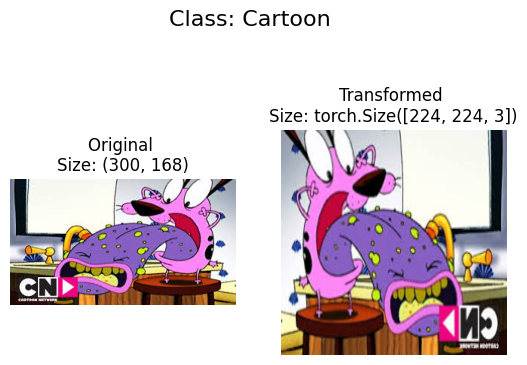

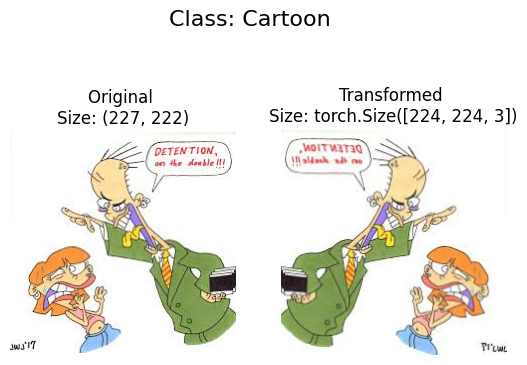

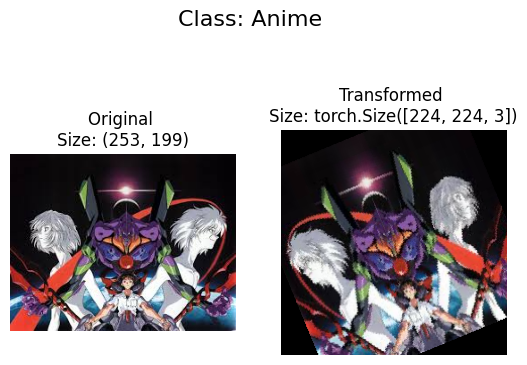

In [69]:
image_path_list = list(image_path.glob("**/*.jpg"))
plot_transformed_images(image_path_list, transform=train_data_transform, n=3)

### load dataset

In [70]:
# Load dataset
# dataset = datasets.ImageFolder(root=image_path, transform=train_data_transform)
dataset = datasets.ImageFolder(root=image_path) # no transform applied

In [71]:
dataset

Dataset ImageFolder
    Number of datapoints: 8892
    Root location: ..\data\Training Data

### train-test split

In [72]:
# Split into train & test
train_size = int(0.8 * len(dataset))  # 80% train, 20% test
test_size = len(dataset) - train_size
train_data, test_data = random_split(dataset, [train_size, test_size])

In [73]:
train_data, test_data

(<torch.utils.data.dataset.Subset at 0x1c38d5e38e0>,
 <torch.utils.data.dataset.Subset at 0x1c38ce5d2a0>)

In [74]:
# Apply different transforms
train_data = TransformedDataset(train_data, train_data_transform)
test_data = TransformedDataset(test_data, test_data_transform)

In [75]:
train_data, test_data

(<__main__.TransformedDataset at 0x1c38d6a69e0>,
 <__main__.TransformedDataset at 0x1c38d6a7340>)

In [76]:
print(f"Train data:\nDataset size: {len(train_data)}\nTransform: {train_data.transform}\n")
print(f"Test data:\nDataset size: {len(test_data)}\nTransform: {test_data.transform}")


Train data:
Dataset size: 7113
Transform: Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
    RandomHorizontalFlip(p=0.5)
    RandomApply(
    p=0.5
    RandomRotation(degrees=[-30.0, 30.0], interpolation=nearest, expand=False, fill=0)
)
    ToTensor()
)

Test data:
Dataset size: 1779
Transform: Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
    ToTensor()
)


In [77]:
class_names = dataset.classes
class_names

['Anime', 'Cartoon']

In [78]:
class_dict = dataset.class_to_idx
class_dict

{'Anime': 0, 'Cartoon': 1}

In [79]:
len(train_data), len(test_data)

(7113, 1779)

can index `train_data`, `test_data` to find samples and their target labels

In [80]:
img, label = train_data[0][0], train_data[0][1]
print(f"Image tensor:\n{img}")
print(f"Image shape: {img.shape}")
print(f"Image datatype: {img.dtype}")
print(f"Image label: {label}")
print(f"Label datatype: {type(label)}")

Image tensor:
tensor([[[0.1686, 0.1333, 0.1333,  ..., 0.0824, 0.0941, 0.1098],
         [0.1608, 0.1176, 0.1137,  ..., 0.0902, 0.1020, 0.1137],
         [0.1608, 0.1176, 0.1098,  ..., 0.0980, 0.1098, 0.1216],
         ...,
         [0.2510, 0.2549, 0.2627,  ..., 0.1686, 0.1804, 0.1765],
         [0.2902, 0.2824, 0.2745,  ..., 0.1765, 0.1882, 0.1765],
         [0.3059, 0.2980, 0.2863,  ..., 0.2000, 0.2118, 0.1961]],

        [[0.2667, 0.2275, 0.2235,  ..., 0.1529, 0.1608, 0.1765],
         [0.2588, 0.2118, 0.2039,  ..., 0.1608, 0.1686, 0.1804],
         [0.2588, 0.2118, 0.2000,  ..., 0.1686, 0.1765, 0.1882],
         ...,
         [0.4392, 0.4431, 0.4510,  ..., 0.3569, 0.3647, 0.3647],
         [0.4784, 0.4706, 0.4627,  ..., 0.3608, 0.3725, 0.3608],
         [0.4941, 0.4863, 0.4745,  ..., 0.3843, 0.3961, 0.3804]],

        [[0.1490, 0.1176, 0.1216,  ..., 0.0706, 0.0902, 0.1059],
         [0.1412, 0.1020, 0.1020,  ..., 0.0745, 0.0980, 0.1098],
         [0.1451, 0.0980, 0.0980,  ..., 0.08

now can plot image tensors as well

Original shape: torch.Size([3, 224, 224]) -> [C, H, W]
Image permute shape: torch.Size([3, 224, 224]) -> [H, W, C]


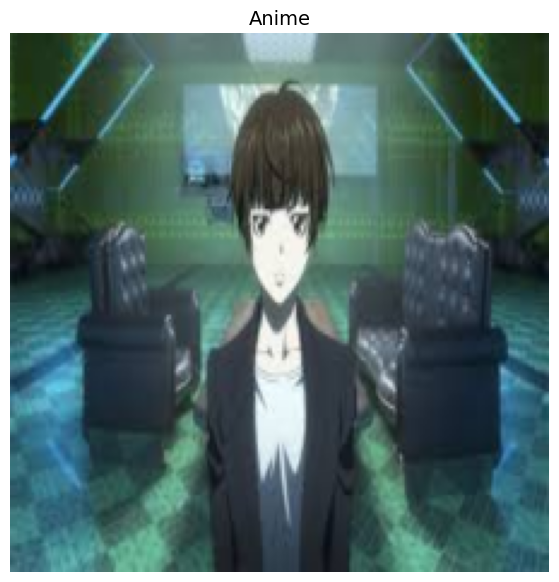

In [81]:
# Rearrange the order of dimensions
img_permute = img.permute(1, 2, 0)

# Print out different shapes (before and after permute)
print(f"Original shape: {img.shape} -> [C, H, W]")
print(f"Image permute shape: {img.shape} -> [H, W, C]")

# Plot the image
plt.figure(figsize=(10, 7))
plt.imshow(img.permute(1, 2, 0))
plt.axis("off")
plt.title(class_names[label], fontsize=14);

In [82]:
# 1. Take in a Dataset as well as a list of class names
def display_random_images(dataset: Dataset,
                          classes: list[str] | None = None,
                          n: int = 10,
                          display_shape: bool = True,
                          seed: int | None = None):
    
    # 2. Adjust display if n too high
    if n > 10:
        n = 10
        display_shape = False
        print(f"For display purposes, n shouldn't be larger than 10, setting to 10 and removing shape display.")
    
    # 3. Set random seed
    if seed:
        random.seed(seed)

    # 4. Get random sample indexes
    random_samples_idx = random.sample(range(len(dataset)), k=n)

    # 5. Setup plot
    plt.figure(figsize=(16, 8))

    # 6. Loop through samples and display random samples 
    for i, targ_sample in enumerate(random_samples_idx):
        targ_image, targ_label = dataset[targ_sample][0], dataset[targ_sample][1]

        # 7. Adjust image tensor shape for plotting: [color_channels, height, width] -> [color_channels, height, width]
        targ_image_adjust = targ_image.permute(1, 2, 0)

        # Plot adjusted samples
        plt.subplot(1, n, i+1)
        plt.imshow(targ_image_adjust)
        plt.axis("off")
        if classes:
            title = f"class: {classes[targ_label]}"
            if display_shape:
                title = title + f"\nshape: {targ_image_adjust.shape}"
        plt.title(title)

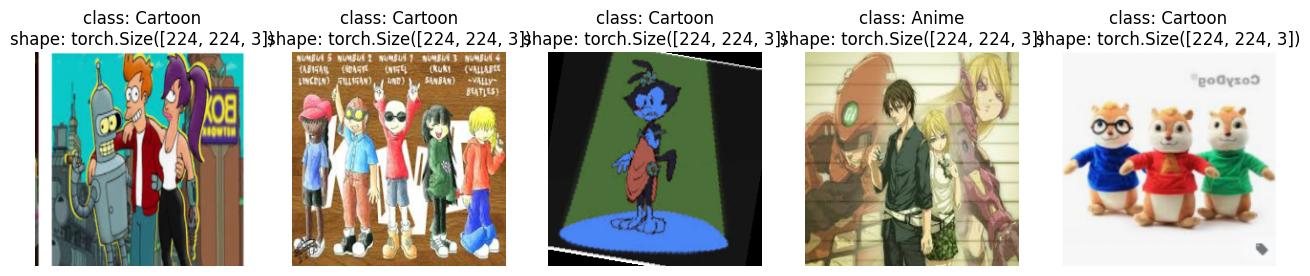

In [83]:
# Display random images from ImageFolder created Dataset
display_random_images(train_data, 
                      n=5, 
                      classes=class_names,
                      seed=None)

### dataloaders

Turning our `Dataset`'s into `DataLoader`'s makes them iterable so a model can go through and learn the relationships between samples and targets (features and labels).

In [84]:
os.cpu_count()

12

In [85]:
# Try loading a single sample without DataLoader
img, label = train_data[0]  # Fetch first sample manually
print(f"Single image type: {type(img)}")  # Should be a torch.Tensor
print(f"Single image shape: {img.shape}")  # Should be [C, H, W]
print(f"Label: {label}")


Single image type: <class 'torch.Tensor'>
Single image shape: torch.Size([3, 224, 224])
Label: 0


In [86]:
# train_dataloader = DataLoader(
#     dataset=train_data, 
#     batch_size=32,  # Start with a small batch
#     num_workers=1,  # Avoid multiprocessing issues for now
#     shuffle=True, 
#     pin_memory=True
# )

# img_batch, label_batch = next(iter(train_dataloader))  # Try fetching a batch
# print(f"Batch Image shape: {img_batch.shape}")  # Should be [batch_size, C, H, W]
# print(f"Batch Label shape: {label_batch.shape}")  # Should be [batch_size]


In [87]:
train_dataloader = DataLoader(dataset=train_data, 
                              batch_size=32, # how many samples per batch?
                              num_workers=0, # number of processes to use, 0 as its showing issues
                              shuffle=True, # shuffle the data?
                              pin_memory=True # copy Tensors into CUDA pinned memory before returning them?
                            )

test_dataloader = DataLoader(dataset=test_data, 
                             batch_size=32, 
                             num_workers=0, 
                             shuffle=False, # don't usually need to shuffle testing data) 
                             pin_memory=True
                            )
train_dataloader, test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x1c38d5e1150>,
 <torch.utils.data.dataloader.DataLoader at 0x1c38d5e2590>)

In [88]:
img_batch, label_batch = next(iter(train_dataloader))  # Try fetching a batch
print(f"Batch Image shape: {img_batch.shape}")  # Should be [batch_size, C, H, W]
print(f"Batch Label shape: {label_batch.shape}")  # Should be [batch_size]

Batch Image shape: torch.Size([32, 3, 224, 224])
Batch Label shape: torch.Size([32])


## model

### load the pretrained model: ResNet50

- load model's DEFAULT weights (best available weights)
- initiate the model with pre trained weights

In [92]:
# NEW: Setup the model with pretrained weights and send it to the target device (torchvision v0.13+)
weights = models.ResNet50_Weights.DEFAULT # .DEFAULT = best available weights 
model = models.resnet50(weights=weights).to(device)

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to C:\Users\ahnaf/.cache\torch\hub\checkpoints\resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:09<00:00, 11.1MB/s]


### freeze classifier layer: fc layer

model summary: before freezing fc layer

In [ ]:
# Print model summary
summary(model=model, 
        input_size=(32, 3, 224, 224), # make sure this is "input_size", not "input_shape"
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
) 

Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
ResNet (ResNet)                          [32, 3, 224, 224]    [32, 1000]           --                   True
├─Conv2d (conv1)                         [32, 3, 224, 224]    [32, 64, 112, 112]   9,408                True
├─BatchNorm2d (bn1)                      [32, 64, 112, 112]   [32, 64, 112, 112]   128                  True
├─ReLU (relu)                            [32, 64, 112, 112]   [32, 64, 112, 112]   --                   --
├─MaxPool2d (maxpool)                    [32, 64, 112, 112]   [32, 64, 56, 56]     --                   --
├─Sequential (layer1)                    [32, 64, 56, 56]     [32, 256, 56, 56]    --                   True
│    └─Bottleneck (0)                    [32, 64, 56, 56]     [32, 256, 56, 56]    --                   True
│    │    └─Conv2d (conv1)               [32, 64, 56, 56]     [32, 64, 56, 56]     4,096                True
│    │    └─BatchN

In [106]:
for param in model.parameters():
    param.requires_grad = False
model.fc.requires_grad_(True)

Linear(in_features=2048, out_features=1000, bias=True)

model summary: after freezing fc layer

In [107]:
# Print model summary
summary(model=model, 
        input_size=(32, 3, 224, 224), # make sure this is "input_size", not "input_shape"
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
) 

Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
ResNet (ResNet)                          [32, 3, 224, 224]    [32, 1000]           --                   Partial
├─Conv2d (conv1)                         [32, 3, 224, 224]    [32, 64, 112, 112]   (9,408)              False
├─BatchNorm2d (bn1)                      [32, 64, 112, 112]   [32, 64, 112, 112]   (128)                False
├─ReLU (relu)                            [32, 64, 112, 112]   [32, 64, 112, 112]   --                   --
├─MaxPool2d (maxpool)                    [32, 64, 112, 112]   [32, 64, 56, 56]     --                   --
├─Sequential (layer1)                    [32, 64, 56, 56]     [32, 256, 56, 56]    --                   False
│    └─Bottleneck (0)                    [32, 64, 56, 56]     [32, 256, 56, 56]    --                   False
│    │    └─Conv2d (conv1)               [32, 64, 56, 56]     [32, 64, 56, 56]     (4,096)              False
│    │    

### updating fc layer as per classification need

In [108]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

output_shape= len(class_names)

model.fc = torch.nn.Linear(
    in_features=model.fc.in_features,
    out_features=len(class_names),
    bias=True
    ).to(device)

In [113]:
# Do a summary *after* freezing the features and changing the output classifier layer
summary(model, 
        input_size=(32, 3, 224, 224),
        verbose=0,
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
ResNet (ResNet)                          [32, 3, 224, 224]    [32, 2]              --                   Partial
├─Conv2d (conv1)                         [32, 3, 224, 224]    [32, 64, 112, 112]   (9,408)              False
├─BatchNorm2d (bn1)                      [32, 64, 112, 112]   [32, 64, 112, 112]   (128)                False
├─ReLU (relu)                            [32, 64, 112, 112]   [32, 64, 112, 112]   --                   --
├─MaxPool2d (maxpool)                    [32, 64, 112, 112]   [32, 64, 56, 56]     --                   --
├─Sequential (layer1)                    [32, 64, 56, 56]     [32, 256, 56, 56]    --                   False
│    └─Bottleneck (0)                    [32, 64, 56, 56]     [32, 256, 56, 56]    --                   False
│    │    └─Conv2d (conv1)               [32, 64, 56, 56]     [32, 64, 56, 56]     (4,096)              False
│    │    

### train setup

In [ ]:
# Define loss and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)